# Experiment 2: Cross-Attention Pattern Analysis

## Theory

In sequence-to-sequence transformers, **cross-attention** in the decoder allows each target token to attend to all source tokens. This mechanism learns implicit **word alignment** between source and target languages.

**Multi-head attention** with $h$ heads:
- Attention weights: $\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$
- Output: weighted sum of values based on query-key similarity

**What we'll visualize:**
1. Single-head attention showing word-to-word alignment

In [11]:
import sys
sys.path.append('..')
import os

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

from modelling.transformer_preln import PreLNTransformer
from modelling.dataloader import MyBPETokenizer

plt.rcParams['font.size'] = 9
plt.rcParams['axes.labelsize'] = 9
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 7
plt.rcParams['ytick.labelsize'] = 7
plt.rcParams['legend.fontsize'] = 8

SINGLE_COL_WIDTH = 3.5
DOUBLE_COL_WIDTH = 7.0
FIG_HEIGHT = 2.5

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

save_dir = '../figures/experiments/cross_attention/'
os.makedirs(save_dir, exist_ok=True)

Using device: cuda:0


## Load Model and Tokenizer

In [2]:
tokenizer = MyBPETokenizer(
    texts=["dummy"],
    vocab_size=37000,
    save_dir='../data/bpe_tokenizer'
)

vocab_size = tokenizer.tokenizer.get_vocab_size()
print(f"Vocabulary size: {vocab_size}")
print(f"BOS token: {tokenizer.bos} (ID: {tokenizer.bos_id})")
print(f"EOS token: {tokenizer.eos} (ID: {tokenizer.eos_id})")

Loading existing tokenizer from ../data/bpe_tokenizer
Vocabulary size: 37000
BOS token: [BOS] (ID: 1)
EOS token: [EOS] (ID: 2)


In [3]:
model = PreLNTransformer(
    vocab_size=vocab_size,
    d_model=512,
    n_heads=8,
    num_encoder_layers=6,
    num_decoder_layers=6,
    max_len=128,
    dim_feedforward=2048,
    dropout=0.1
).to(device)

checkpoint = torch.load('../checkpoints_preln/best_model.pt', map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded model with {sum(p.numel() for p in model.parameters()):,} parameters")

Loaded model with 82,028,680 parameters


In [8]:
def get_cross_attention_weights(model, src_text, max_len=50):
    """
    Generate translation and extract cross-attention weights by manually computing them.
    No hooks or model modification needed - we compute attention directly.
    """
    model.eval()
    
    # Encode source
    src_ids = tokenizer.encode_src(src_text, max_length=128).unsqueeze(0).to(device)
    src_mask = (src_ids != tokenizer.pad_id).to(device)
    
    with torch.no_grad():
        memory = model.encode(src_ids, src_mask)
    
    # Start with BOS token
    tgt = torch.tensor([[tokenizer.bos_id]], dtype=torch.long, device=device)
    all_attentions = []
    
    # Generate tokens one by one
    for step in range(max_len - 1):
        with torch.no_grad():
            # Embed target
            tgt_embedded = model.embedding(tgt) * (model.d_model ** 0.5)
            tgt_embedded = model.positional_encoding(tgt_embedded)
            
            x = tgt_embedded
            
            # Go through decoder layers manually
            layer_attentions = []
            for layer in model.decoder_layers:
                # Self-attention
                x_norm = layer.layer_norm_1(x)
                self_attn_out = layer.self_attention(x_norm, x_norm, x_norm, attention_mask=None, future_mask=True)
                x = x + self_attn_out
                
                # Cross-attention - MANUALLY COMPUTE ATTENTION WEIGHTS
                x_norm = layer.layer_norm_2(x)
                
                # Extract Q, K, V
                q = layer.encoder_attention.query_transform(x_norm)
                k = layer.encoder_attention.key_transform(memory)
                v = layer.encoder_attention.value_transform(memory)
                
                B, Tq, _ = q.shape
                _, Tk, _ = k.shape
                
                # Reshape to multi-head format
                num_heads = layer.encoder_attention.num_head
                head_dim = layer.encoder_attention.head_dim
                
                q = q.view(B, Tq, num_heads, head_dim).permute(0, 2, 1, 3)  # [B, h, Tq, d_k]
                k = k.view(B, Tk, num_heads, head_dim).permute(0, 2, 1, 3)  # [B, h, Tk, d_k]
                v = v.view(B, Tk, num_heads, head_dim).permute(0, 2, 1, 3)  # [B, h, Tk, d_k]
                
                # Compute attention scores
                scores = (q @ k.transpose(-2, -1)) / np.sqrt(head_dim)
                
                # Apply source mask
                if src_mask is not None:
                    key_pad = (src_mask.squeeze(1) == 0).unsqueeze(1).unsqueeze(1)  # [B, 1, 1, Tk]
                    scores = scores.masked_fill(key_pad, float("-inf"))
                
                # Attention weights
                attn_weights = torch.softmax(scores, dim=-1)  # [B, h, Tq, Tk]
                
                # Store attention for last query position only
                layer_attentions.append(attn_weights[:, :, -1:, :].cpu())  # [B, h, 1, Tk]
                
                # Continue with actual cross-attention output
                cross_attn_out = layer.encoder_attention(x_norm, memory, memory, 
                                                         attention_mask=src_mask, future_mask=False)
                x = x + cross_attn_out
                
                # FFN
                x_norm = layer.layer_norm_3(x)
                ffn_out = layer.feature_transformation(x_norm)
                x = x + ffn_out
            
            # Final norm and projection
            x = model.decoder_final_norm(x)
            logits = model.output_projection(x)
            
            # Get next token
            next_token = torch.argmax(logits[:, -1, :], dim=-1, keepdim=True)
            tgt = torch.cat([tgt, next_token], dim=1)
            
            # Stack layer attentions: [num_layers, B, h, 1, Tk]
            all_attentions.append(torch.stack(layer_attentions, dim=0))
            
            if next_token.item() == tokenizer.eos_id:
                break
    
    # Process attentions: concatenate across target positions
    # all_attentions is a list of [num_layers, B, h, 1, Tk] tensors
    attentions = torch.cat(all_attentions, dim=3)  # [num_layers, B, h, total_tgt_len, Tk]
    attentions = attentions.squeeze(1)  # Remove batch dim: [num_layers, h, total_tgt_len, Tk]
    
    # Decode tokens
    src_tokens = tokenizer.decode(src_ids[0].cpu().tolist())
    tgt_tokens = tokenizer.decode(tgt[0].cpu().tolist())
    
    return tgt_tokens, src_tokens, attentions

## Select Translation Examples

In [17]:
with open('../data/cleaned_wmt17_de_en_split_test.json', 'r') as f:
    test_data = json.load(f)

# Try a few different examples to find good translations
for example_idx, example in enumerate(test_data[:200]):
    src_text = example['src']
    tgt_reference = example['tgt']
    
    tgt_tokens, src_tokens, attentions = get_cross_attention_weights(model, src_text)
    
    print(f"Example {example_idx}")
    print(f"Source (DE): {src_text}")
    print(f"Reference (EN): {tgt_reference}")
    print(f"Prediction: {tgt_tokens}")

# Pick the best one for visualization
example_idx = 78  # Change this based on which translation looks best
example = test_data[example_idx]
src_text = example['src']
tgt_reference = example['tgt']

tgt_tokens, src_tokens, attentions = get_cross_attention_weights(model, src_text)

print(f"Selected for visualization")
print(f"Source (DE): {src_text}")
print(f"Reference (EN): {tgt_reference}")
print(f"Prediction: {tgt_tokens}")


Example 0
Source (DE): 28-jähriger Koch in San Francisco Mall tot aufgefunden
Reference (EN): 28-Year-Old Chef Found Dead at San Francisco Mall
Prediction: 28 - 28 - san francisco in san francisco
Example 1
Source (DE): Ein 28-jähriger Koch, der vor kurzem nach San Francisco gezogen ist, wurde im Treppenhaus eines örtlichen Einkaufzentrums tot aufgefunden.
Reference (EN): A 28-year-old chef who had recently moved to San Francisco was found dead in the stairwell of a local mall this week.
Prediction: a 28 - year - old town of the san francisco , was built in the centre of the city centre of the city .
Example 2
Source (DE): Der Bruder des Opfers sagte aus, dass er sich niemanden vorstellen kann, der ihm schaden wollen würde,  Endlich ging es bei ihm wieder bergauf. 
Reference (EN): But the victim s brother says he can t think of anyone who would want to hurt him, saying,  Things were finally going well for him. 
Prediction: the ophest said he said that he could not be able to imagine th

Attention shape: (12, 12)
Source tokens: 12, Target tokens: 11


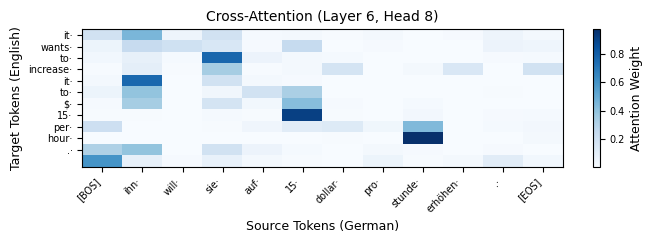

In [ ]:
layer_idx = 5
head_idx = 7

attn_matrix = attentions[layer_idx, head_idx].squeeze().numpy()

# Remove padding tokens trim to actual source length
src_ids = tokenizer.encode_src(src_text, max_length=128)
actual_src_len = (src_ids != tokenizer.pad_id).sum().item()
attn_matrix = attn_matrix[:, :actual_src_len]

src_tokens_list = [tokenizer.tokenizer.id_to_token(id.item()) for id in src_ids[:actual_src_len]]
tgt_ids = tokenizer.encode_tgt(tgt_tokens, max_length=128)
tgt_tokens_list = [tokenizer.tokenizer.id_to_token(id.item()) for id in tgt_ids if id.item() not in [tokenizer.pad_id, tokenizer.bos_id, tokenizer.eos_id]]

# remove </w> suffix
src_tokens_list = [t.replace('</w>', '·') for t in src_tokens_list]
tgt_tokens_list = [t.replace('</w>', '·') for t in tgt_tokens_list]

print(f"Attention shape: {attn_matrix.shape}")
print(f"Source tokens: {len(src_tokens_list)}, Target tokens: {len(tgt_tokens_list)}")

fig, ax = plt.subplots(figsize=(DOUBLE_COL_WIDTH, FIG_HEIGHT))
im = ax.imshow(attn_matrix, cmap='Blues', aspect='auto')
ax.set_xlabel('Source Tokens (German)')
ax.set_ylabel('Target Tokens (English)')
ax.set_title(f'Cross-Attention (Layer {layer_idx+1}, Head {head_idx+1})')
ax.set_xticks(range(len(src_tokens_list)))
ax.set_xticklabels(src_tokens_list, rotation=45, ha='right')
ax.set_yticks(range(len(tgt_tokens_list)))
ax.set_yticklabels(tgt_tokens_list)
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('Attention Weight')
plt.tight_layout()
plt.savefig(save_dir + 'cross_attention_single_head.pdf', dpi=300, bbox_inches='tight')
plt.savefig(save_dir + 'cross_attention_single_head.png', dpi=300, bbox_inches='tight')
plt.show()